In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix as plotCM

In [97]:
def trainTestSplit(dataset):
    training_data = dataset.sample(frac=0.8, random_state=2)
    testing_data = dataset.drop(training_data.index)
    training_data = training_data.reset_index(drop=True)
    testing_data = testing_data.reset_index(drop=True)
    return training_data,testing_data

In [98]:
def load_data(dropLabels = ["gameId"]):
    data = pd.read_csv('high_diamond_ranked_10min.csv', delimiter=',', header=0)
    data = data.drop(labels=dropLabels,axis=1)
    training_data, testing_data = trainTestSplit(data)
    x_test = testing_data.iloc[:,1:]
    y_test = testing_data.iloc[:,0].astype(np.int)
    x_train = training_data.iloc[:,1:]
    y_train = training_data.iloc[:,0].astype(np.int)
    return x_train.to_numpy(), y_train, x_test.to_numpy(), y_test

In [99]:
dropLabels =  ["gameId", "blueGoldDiff","blueExperienceDiff", "blueGoldPerMin", "redGoldDiff", 
               "redExperienceDiff", "redGoldPerMin", "redFirstBlood"]

# Principle Component Analysis

In [100]:
x_train, y_train, x_test, y_test = load_data()
pca = PCA(n_components=2) #10 dimensions to determine reduction overlap
pca.fit(x_train)
pca10 = PCA(n_components=10) #10 dimensions to determine reduction overlap
pca10.fit(x_train)
print(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_) * 100)
print(np.cumsum(pca10.explained_variance_)/np.sum(pca10.explained_variance_) * 100)
#first eigenvalue contains 93% of the accuracy with 2 dimensions and 86% with 10 dimensions

[ 93.10361622 100.        ]
[ 85.94270427  92.30866399  96.75694617  99.99477991  99.99607138
  99.99732797  99.99841796  99.99944826  99.99974535 100.        ]


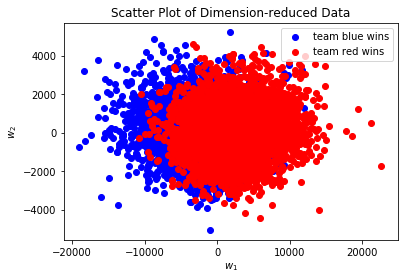

In [101]:
Pd = pca.components_
W = np.dot((x_train - pca.mean_), Pd.T)
pl.figure()
pl.title('Scatter Plot of Dimension-reduced Data')
K = 2
for k in np.arange(K):
    pl.scatter(W[y_train==1-k][:,0], W[y_train==1-k][:, 1], label='team {:s} wins'.format("red" if 1-k==0 else "blue"), c=("red" if 1-k==0 else "blue"))
pl.xlabel(r'$w_{1}$')
pl.ylabel(r'$w_{2}$')
pl.legend();

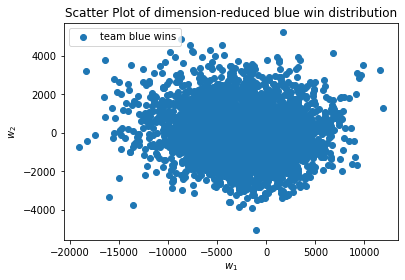

In [102]:
pl.figure()
pl.title('Scatter Plot of dimension-reduced blue win distribution')
K = 2
for k in np.arange(K):
    if k == 0:
        pl.scatter(W[y_train==1-k][:,0], W[y_train==1-k][:, 1], label='team {:s} wins'.format("red" if 1==0 else "blue"))
pl.xlabel(r'$w_{1}$')
pl.ylabel(r'$w_{2}$')
pl.legend();

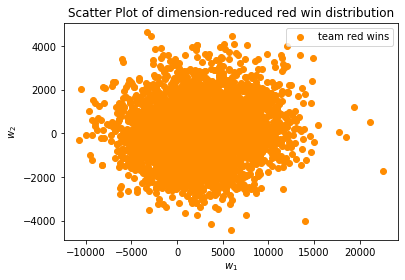

In [103]:
pl.title('Scatter Plot of dimension-reduced red win distribution')
K = 2
for k in np.arange(K):
    if k == 1:
        pl.scatter(W[y_train==1-k][:,0], W[y_train==1-k][:, 1], label='team {:s} wins'.format("red" if 1-k==0 else "blue"), c='darkOrange')
pl.xlabel(r'$w_{1}$')
pl.ylabel(r'$w_{2}$')
pl.legend();

Text(0.5, 0, '$w_{1}$')

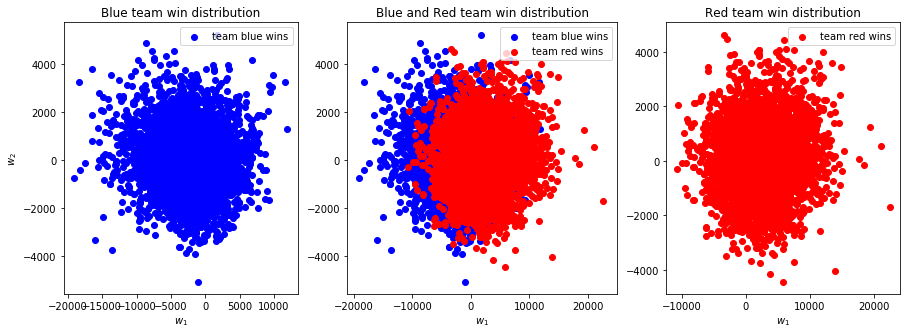

In [104]:
from matplotlib import gridspec
fig, axs = pl.subplots(1,3, figsize=(15,5))
gs = gridspec.GridSpec(1,3,width_ratios=[6.5, 7.5,6.5], wspace=0.2) 
axs[0] = pl.subplot(gs[0])
axs[0].scatter(W[y_train==1][:,0], W[y_train==1][:, 1], label='team {:s} wins'.format("red" if 1==0 else "blue"), c=("red" if 1==0 else "blue"))
axs[0].legend(loc="upper right")
axs[0].set_title('Blue team win distribution')
axs[0].set_xlabel(r'$w_{1}$')
axs[0].set_ylabel(r'$w_{2}$')
axs[1] = pl.subplot(gs[1])
K = 2
for k in np.arange(K):
    axs[1].scatter(W[y_train==1-k][:,0], W[y_train==1-k][:, 1], label='team {:s} wins'.format("red" if 1-k==0 else "blue"), c=("red" if 1-k==0 else "blue"))
axs[1].legend(loc="upper right")
axs[1].set_title('Blue and Red team win distribution')
axs[1].set_xlabel(r'$w_{1}$')
axs[2] = pl.subplot(gs[2])
axs[2].scatter(W[y_train==0][:,0], W[y_train==0][:, 1], label='team {:s} wins'.format("red" if 0==0 else "blue"), c=("red" if 1-k==0 else "blue"))
axs[2].legend(loc="upper right")
axs[2].set_title('Red team win distribution')
axs[2].set_xlabel(r'$w_{1}$')

# Logistic Regression

In [105]:
x_train, y_train, x_test, y_test = load_data(dropLabels)
data = pd.read_csv('high_diamond_ranked_10min.csv', delimiter=',', header=0)
data = data.drop(labels=dropLabels,axis=1)
training_data, testing_data = trainTestSplit(data)
data = testing_data.iloc[:,1:]
print(np.sum(y_train)/len(y_train)) #base winrate

0.4970264456535493


In [106]:
sgd = SGD(loss='log',penalty="l2", alpha = 0.0001,max_iter = 150, random_state=0)
sgd.fit(x_train,y_train)
print(sgd.score(x_train, y_train))
print(sgd.score(x_test, y_test))
np.set_printoptions(suppress=True)
for i in range(len(sgd.coef_.T)):
    #print(str(i) + '\t'+ str(np.around(sgd.coef_.T[i],7)) + '\t ' + str(data.columns[i]))
    print(str(i+1) + '\t'+ str(data.columns[i]) + '\t ' + str(np.around(sgd.coef_.T[i],7)[0]))
print(sgd.intercept_)
print(sgd.average)
print(np.mean(sgd.coef_))
variance = (sgd.coef_-np.mean(sgd.coef_))

0.7150449196507656
0.7145748987854251
1	blueWardsPlaced	 -1485.1791027
2	blueWardsDestroyed	 -5.1068185
3	blueFirstBlood	 45.0158463
4	blueKills	 70.3224071
5	blueDeaths	 -117.087718
6	blueAssists	 76.7539646
7	blueEliteMonsters	 226.3786893
8	blueDragons	 221.5095149
9	blueHeralds	 4.8691744
10	blueTowersDestroyed	 -10.9923003
11	blueTotalGold	 2152.1599311
12	blueAvgLevel	 0.5652894
13	blueTotalExperience	 690.9120876
14	blueTotalMinionsKilled	 -2230.2082975
15	blueTotalJungleMinionsKilled	 1454.9477487
16	blueCSPerMin	 -223.0208298
17	redWardsPlaced	 -1350.2326889
18	redWardsDestroyed	 -123.9743385
19	redKills	 -117.087718
20	redDeaths	 70.3224071
21	redAssists	 -129.1923946
22	redEliteMonsters	 -236.4709761
23	redDragons	 -210.1379953
24	redHeralds	 -26.3329807
25	redTowersDestroyed	 13.1766029
26	redTotalGold	 -2063.8827598
27	redAvgLevel	 -4.734678
28	redTotalExperience	 -881.6846234
29	redTotalMinionsKilled	 2430.6382815
30	redTotalJungleMinionsKilled	 -536.4384138
31	redCSPerMi

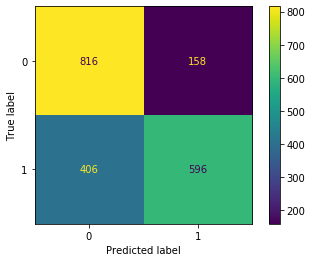

In [107]:
plotCM(sgd, x_test, y_test)

In [108]:
dropLabelsRelevant = dropLabels.copy()
irrelevant = data.columns[np.where(np.abs(sgd.coef_)<np.abs(np.mean(sgd.coef_)))[1]]
for i in range(len(irrelevant)):
    dropLabelsRelevant.append(irrelevant[i])
x_trainR, y_trainR, x_testR, y_testR = load_data(dropLabelsRelevant)
dataR = pd.read_csv('high_diamond_ranked_10min.csv', delimiter=',', header=0)
dataR = dataR.drop(labels=dropLabelsRelevant,axis=1)
dataR = dataR.iloc[:,1:]
print(len(x_trainR[0]))
sgdR = SGD(loss='log',penalty="l2", alpha = 0.0001,max_iter = 1500, random_state=0)
sgdR.fit(x_trainR,y_trainR)
print(sgdR.score(x_trainR, y_trainR))
print(sgdR.score(x_testR, y_testR))

23
0.6880931291914463
0.687753036437247


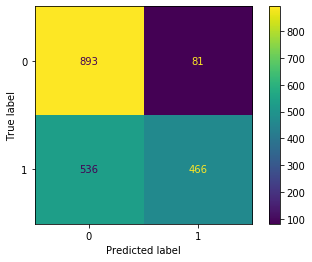

In [109]:
plotCM(sgdR, x_testR, y_testR)

# Decision Tree and Random Forest

In [110]:
tree2 = DT(max_depth=2, random_state=0)
tree5 = DT(max_depth=5, random_state=0)
tree2.fit(x_train, y_train)
tree5.fit(x_train, y_train)

print(tree2.score(x_test, y_test))
print(tree5.score(x_test, y_test))
for i in range(10):
    tree = DT(max_depth=i+1, random_state=0)
    tree.fit(x_train, y_train)
    print(i+1, tree.score(x_train, y_train), tree.score(x_test, y_test))


tree = DT(max_depth=6, random_state=0)
tree.fit(x_train, y_train)
tree_rules = export_text(tree, feature_names=list(data.columns))
print(tree_rules)

0.6837044534412956
0.7186234817813765
1 0.6812602809059851 0.6751012145748988
2 0.6815133493610022 0.6837044534412956
3 0.7141591800582058 0.6998987854251012
4 0.7223839048462609 0.7115384615384616
5 0.733392382639504 0.7186234817813765
6 0.7390864228773883 0.7135627530364372
7 0.7586992281412122 0.7044534412955465
8 0.7776793622674933 0.6998987854251012
9 0.7998228520814881 0.6902834008097166
10 0.8295583955459952 0.6842105263157895
|--- blueTotalGold <= 16388.50
|   |--- redTotalGold <= 16233.50
|   |   |--- redTotalGold <= 15109.50
|   |   |   |--- redWardsPlaced <= 64.50
|   |   |   |   |--- redTotalExperience <= 17174.50
|   |   |   |   |   |--- blueWardsDestroyed <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- blueWardsDestroyed >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- redTotalExperience >  17174.50
|   |   |   |   |   |--- blueDragons <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- blueDragons >  0.50
|   | 

In [ ]:
fig, ax = pl.subplots(figsize=(20, 10))
plot_tree(tree, max_depth = 3,fontsize=10, feature_names=list(data.columns));
pl.show()
fig.savefig('DecisionTree.png')

In [93]:
for i in range(10):
    for j in range(10):
        rf = RF(i+1, max_depth=j+1, random_state=0)
        rf.fit(x_train,y_train)
        print(i+1, j+1, rf.score(x_train,y_train), rf.score(x_test,y_test))

1 1 0.6467164367961533 0.6497975708502024
1 2 0.6536758193091231 0.6563765182186235
1 3 0.7037833734025054 0.7019230769230769
1 4 0.7130203720106288 0.7039473684210527
1 5 0.7083386055928128 0.7059716599190283
1 6 0.7202328229786157 0.6953441295546559
1 7 0.7216246994812097 0.6882591093117408
1 8 0.7419967101100847 0.6761133603238867
1 9 0.7556624066810073 0.6816801619433198
1 10 0.7660382133367076 0.6594129554655871
2 1 0.6648108313298747 0.6654858299595142
2 2 0.6792357332658484 0.6761133603238867
2 3 0.7093508794128812 0.7120445344129555
2 4 0.7173225357459193 0.7074898785425101
2 5 0.7236492471213464 0.7125506072874493
2 6 0.7338985195495381 0.7054655870445344
2 7 0.7455396684803239 0.7100202429149798
2 8 0.7685688978868784 0.6907894736842105
2 9 0.7817284575477667 0.6629554655870445
2 10 0.8045046184993041 0.6634615384615384
3 1 0.6583575857269391 0.6417004048582996
3 2 0.6788561305833228 0.6761133603238867
3 3 0.7145387827407313 0.7049595141700404
3 4 0.7237757813488549 0.7085020

In [94]:
m = 0
tr = 0
te = 0
maxTe = 0
for i in range(100):
    rf = RF(i+1, max_depth=6, random_state=0)
    rf.fit(x_train,y_train)
    tr = rf.score(x_train,y_train)
    te = rf.score(x_test,y_test)
    if te > maxTe:
        maxTe = te
        m = i+1
    print(i+1, tr, te)
print(m,maxTe)

1 0.7202328229786157 0.6953441295546559
2 0.7338985195495381 0.7054655870445344
3 0.7436416550676959 0.7130566801619433
4 0.750474503353157 0.7211538461538461
5 0.7528786536758193 0.7257085020242915
6 0.7500949006706314 0.7322874493927125
7 0.7536378590408706 0.7257085020242915
8 0.7540174617233962 0.7282388663967612
9 0.7527521194483108 0.728744939271255
10 0.7543970644059218 0.7282388663967612
11 0.755156269770973 0.7277327935222672
12 0.7542705301784133 0.7282388663967612
13 0.7566746805010756 0.7257085020242915
14 0.7561685435910414 0.7277327935222672
15 0.7550297355434645 0.7262145748987854
16 0.7561685435910414 0.7272267206477733
17 0.7561685435910414 0.7282388663967612
18 0.7560420093635328 0.728744939271255
19 0.7560420093635328 0.728744939271255
20 0.7552828039984816 0.729251012145749
21 0.7538909274958876 0.729757085020243
22 0.7554093382259901 0.729251012145749
23 0.7557889409085158 0.7282388663967612
24 0.754903201315956 0.7277327935222672
25 0.7555358724534986 0.7292510121

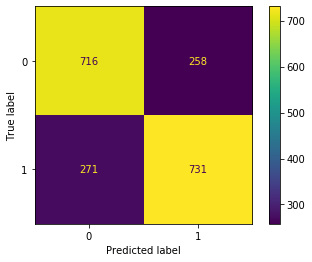

In [95]:
rf = RF(6, max_depth=6, random_state=0)
rf.fit(x_train,y_train)
plotCM(rf, x_test, y_test)